<a href="https://colab.research.google.com/github/marcusnk237/ECG-Classification-COVID/blob/main/ECG_COVID_Classification_2CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import glob
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import csv
import itertools
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import seaborn as sn
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
from imutils import paths
import time
import cv2
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.preprocessing import image
from sklearn.utils import shuffle
from tqdm import tqdm
from collections import Counter
import os.path, sys, re
import time
from PIL import Image
from tensorflow.keras.layers import GaussianNoise

from keras.callbacks import EarlyStopping, ModelCheckpoint

Populating the interactive namespace from numpy and matplotlib


In [ ]:
!pip install -U -q kaggle==1.5.8
########################

### Select kaggle.json file ##
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"marcjuniornkengue","key":"58445b157d5149ac1ddb370e10df9c47"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d marcjuniornkengue/ecg-image-cropped

100% 1.31G/1.31G [00:15<00:00, 75.4MB/s]
100% 1.31G/1.31G [00:15<00:00, 92.6MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead2.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead3.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead4.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead5.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead6.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead7.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead8.png  
  inflating: ECG/Normal/Cropped_Images/Normal_165Cropped_lead9.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead1.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead10.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead11.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead12.png  
  inflating: ECG/Normal/Cropped_Images/Normal_166Cropped_lead13.png  
  inflating: ECG/Norm

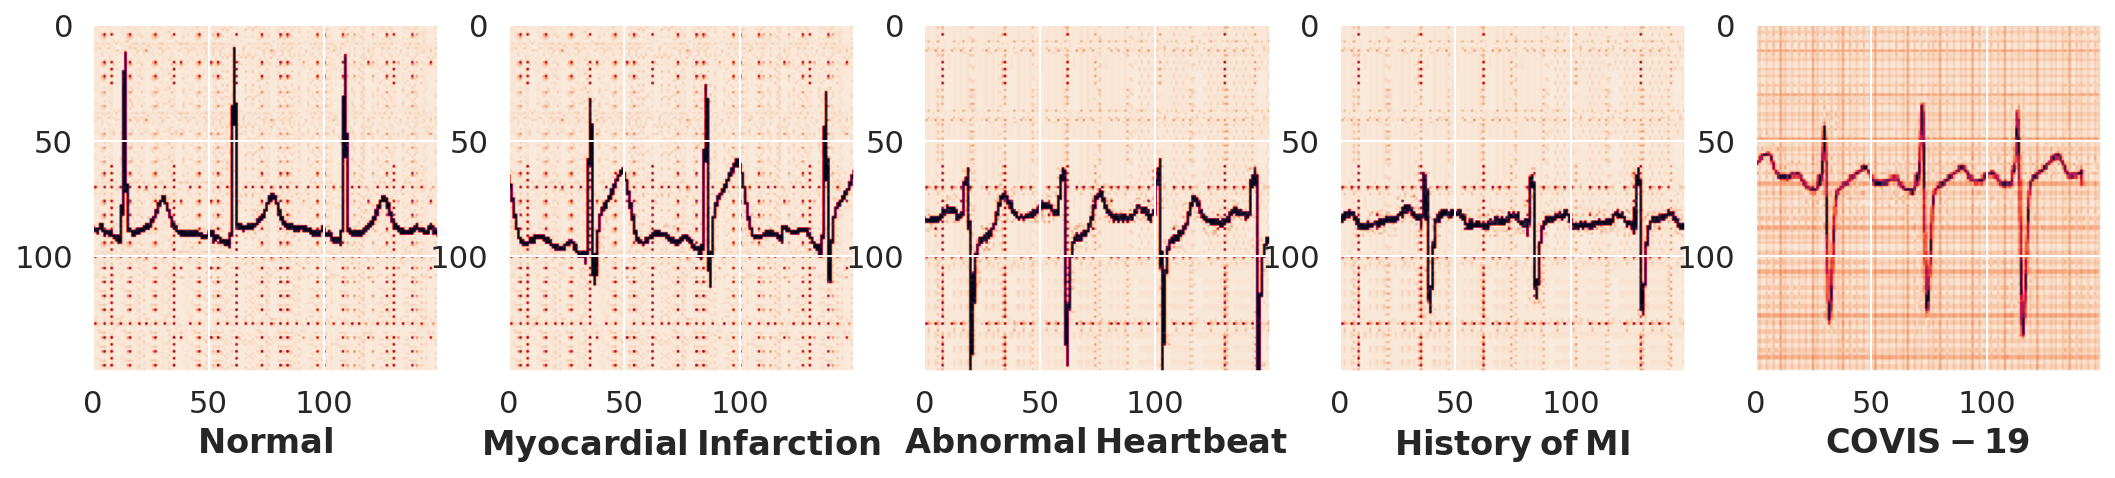

In [ ]:
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, figsize=(18, 5))
img0 = image.load_img('/content/ECG/Normal/Cropped_Images/Normal_100Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax1.imshow(img0)
ax1.set_xlabel(r"$\bf{Normal}$")
img1 = image.load_img('/content/ECG/MI/Cropped_Images/MI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax2.imshow(img1)
ax2.set_xlabel(r"$\bf{Myocardial\: Infarction}$")
img2 = image.load_img('/content/ECG/HB/Cropped_Images/HB_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax3.imshow(img2)
ax3.set_xlabel(r"$\bf{Abnormal\:  Heartbeat}$")
img3 = image.load_img('/content/ECG/PMI/Cropped_Images/PMI_20Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax4.imshow(img3)
ax4.set_xlabel(r"$\bf{History\:  of\:  MI}$")
img4 = image.load_img('/content/ECG/COVID/Cropped_Images/Binder1_Page_001Cropped_lead4.png', grayscale=True, target_size=(150,150)) #target_size=(28,28), grayscale=True
ax5.imshow(img4)
ax5.set_xlabel(r"$\bf{COVIS-19}$")

fig.savefig("representative_ECG_images.png",dpi=300)

In [ ]:
images = []
labels = []

dirs = ['Normal','HB','PMI', 'MI','COVID']

for dir in dirs:
  print(dir)
  for filename in os.listdir('/content/ECG/{}/Cropped_Images/'.format(dir)):
    if filename.endswith("png") and "lead4" in filename:
      images.append('/content/ECG/{}/Cropped_Images/{}'.format(dir,filename))
      labels.append(dirs.index(dir))

df = pd.DataFrame({"image":images, "label":labels})
df.to_csv("ECG_covid_set.csv", index=False)

Normal
HB
PMI
MI
COVID


In [ ]:
imagedata = []
for i in tqdm(range(df.shape[0])):
    img = image.load_img('{}'.format(df["image"][i]), target_size=(150,150,1), grayscale=True) #, grayscale=True
    #img = add_gaussian_noise(img_raw)
    img = image.img_to_array(img)
    img = img/255
    imagedata.append(img)
X = np.array(imagedata)

100%|██████████| 1178/1178 [00:02<00:00, 516.00it/s]


In [ ]:
y=df['label'].values
y = to_categorical(y) #one-hot encoding

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2, shuffle=True, stratify=y)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(128, kernel_size=(3, 3),activation='relu',input_shape=(150,150,1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.GaussianNoise(0.1))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 148, 148, 128)     1280      
                                                                 
 conv2d_18 (Conv2D)          (None, 146, 146, 64)      73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 conv2d_20 (Conv2D)          (None, 69, 69, 32)        9248      
                                                                 
 flatten_4 (Flatten)         (None, 152352)            0         
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
history=model.fit(X_train, y_train, epochs=30, batch_size=32,callbacks=callbacks,validation_data=(X_test, y_test))
model.load_weights('best_model.h5')

Epoch 1/30
30/30 [==============================] - 4s 118ms/step - loss: 1.7275 - accuracy: 0.2091 - val_loss: 1.5899 - val_accuracy: 0.2119
Epoch 2/30
30/30 [==============================] - 3s 112ms/step - loss: 1.4730 - accuracy: 0.3248 - val_loss: 1.0219 - val_accuracy: 0.6102
Epoch 3/30
30/30 [==============================] - 3s 113ms/step - loss: 0.6440 - accuracy: 0.7781 - val_loss: 0.6234 - val_accuracy: 0.7881
Epoch 4/30
30/30 [==============================] - 3s 111ms/step - loss: 0.2533 - accuracy: 0.9140 - val_loss: 0.4751 - val_accuracy: 0.8517
Epoch 5/30
30/30 [==============================] - 3s 103ms/step - loss: 0.0797 - accuracy: 0.9713 - val_loss: 1.3057 - val_accuracy: 0.7331
Epoch 6/30
30/30 [==============================] - 3s 103ms/step - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.5680 - val_accuracy: 0.8559
Epoch 7/30
30/30 [==============================] - 3s 104ms/step - loss: 0.0266 - accuracy: 0.9904 - val_loss: 0.6897 - val_accuracy: 0.8686
Epoch 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4751114547252655
Test accuracy: 0.8516949415206909


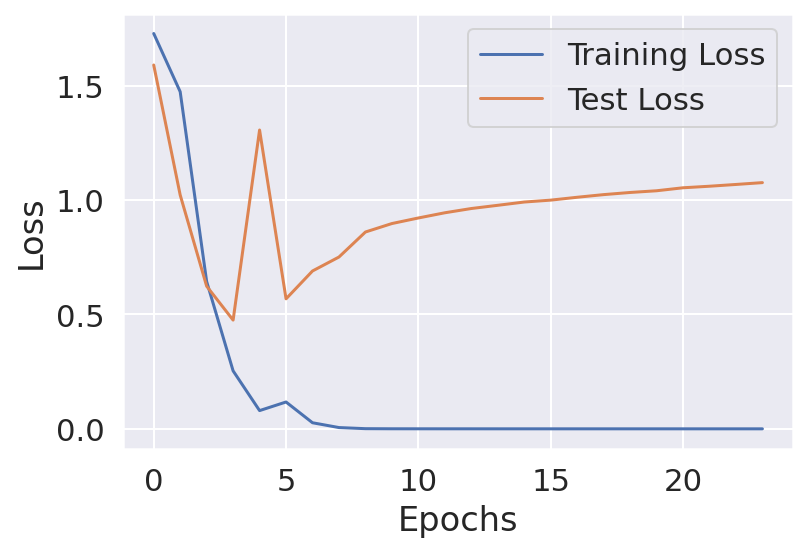

In [ ]:
plt.plot(history.history['loss'],label="Training Loss")
plt.plot(history.history['val_loss'],label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss_2DCNN.png", dpi=300, bbox_inches="tight")

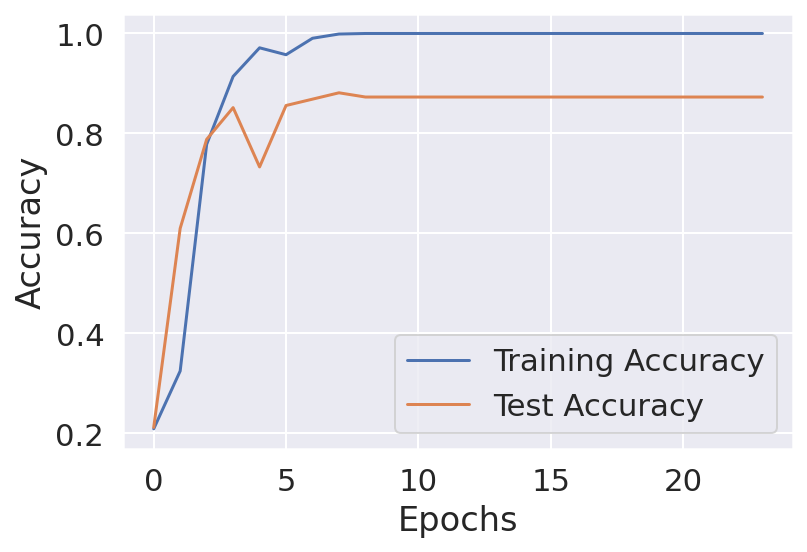

In [ ]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("Accuracy_2DCNN.png", dpi=300, bbox_inches="tight")

In [ ]:
import sklearn.metrics as metrics

y_test_pred = model.predict(X_test)  
y_test_pred_labels = np.argmax(y_test_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
# print(y_test_pred_labels)
y_test_labels = np.argmax(y_test, axis=1)
# print(y_test_labels)
confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=y_test_pred_labels) 

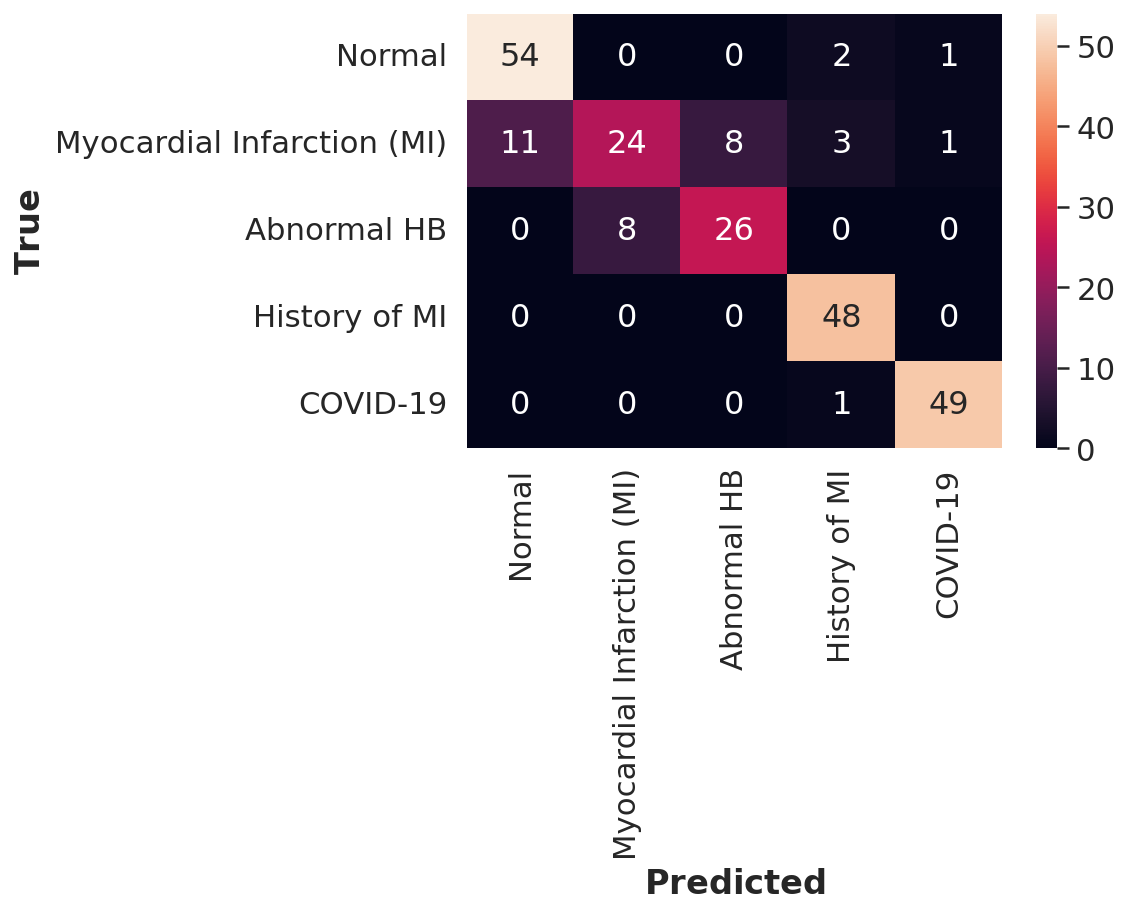

In [ ]:
x_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI", "COVID-19"]
y_axis_labels = ["Normal", "Myocardial Infarction (MI)", "Abnormal HB", "History of MI","COVID-19"]

df_cm = pd.DataFrame(confusion_matrix, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g',xticklabels=x_axis_labels, yticklabels=y_axis_labels) # font size

plt.xlabel(r"$\bf{Predicted}$")
plt.ylabel(r"$\bf{True}$")

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# red_patch = mpatches.Patch(color=None, label='The red data')
# blue_patch = mpatches.Patch(color='blue', label='The blue data')

# plt.legend(handles=[red_patch, blue_patch], bbox_to_anchor=(1.25, 1), loc='upper left')
# plt.tight_layout()
plt.savefig("Confusion_matrix_2DCNN.png", dpi=300, bbox_inches="tight")

plt.show()

In [ ]:
from sklearn.metrics import classification_report

df = pd.DataFrame(classification_report(y_test_pred_labels, 
                                        y_test_labels, digits=2,
                                        output_dict=True)).T
df['support'] = df.support.apply(int)
df.rename(index={'0':'Normal', '1':'Abnormal HB', '2':'History of MI' ,'3':'Myocardial Infarction (MI)','4': 'COVID-19'}, inplace=True)
df = df[0:5]
df.style.background_gradient(cmap='viridis')

,precision,recall,f1-score,support
Normal,0.947368,0.830769,0.885246,65
Abnormal HB,0.510638,0.750000,0.607595,32
History of MI,0.764706,0.764706,0.764706,34
Myocardial Infarction (MI),1.000000,0.888889,0.941176,54
COVID-19,0.980000,0.960784,0.970297,51


Input image shape is  (110, 152, 3)
the resized image has shape  (150, 150, 3)
image shape after expanding dimensions is  (1, 150, 150, 3)
the shape of prediction is  (1, 5)
the image is predicted as being COVID with a probability of  98.52 %


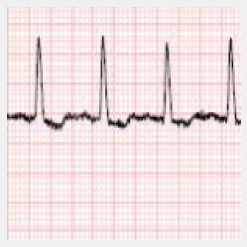

In [ ]:
img=plt.imread(img_path)
print ('Input image shape is ', img.shape)
# resize the image so it is the same size as the images the model was trained on
img=cv2.resize(img, img_size) # in earlier code img_size=(224,224) was used for training the model
print ('the resized image has shape ', img.shape)
### show the resized image
plt.axis('off')
plt.imshow(img)
# Normally the next line of code rescales the images. However the EfficientNet model expects images in the range 0 to 255
# img= img/255
# plt.imread returns a numpy array so it is not necessary to convert the image to a numpy array
# since we have only one image we have to expand the dimensions of img so it is off the form (1,224,224,3)
# where the first dimension 1 is the batch size used by model.predict
img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
# now predict the image
pred=model.predict(img)
print ('the shape of prediction is ', pred.shape)
# this dataset has 15 classes so model.predict will return a list of 15 probability values
# we want to find the index of the column that has the highest probability
index=np.argmax(pred[0])
# to get the actual Name of the class earlier Imade a list of the class names called classes
klass=classes[index]
# lets get the value of the highest probability
probability=pred[0][index]*100
# print out the class, and the probability 
print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')